Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [74]:
from random import random, seed
from itertools import accumulate
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from collections import deque

from icecream import ic

np.set_printoptions(linewidth=200)

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [75]:
UNIVERSE_SIZE = 10_000
NUM_SETS = 1_000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [76]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

In [77]:
""" I would like to use the same starting solutions for all algorithms """
starting_solution = rng.random(NUM_SETS) < 0.9

## Helper Functions

In [78]:
def valid(solution: np.ndarray) -> bool:
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution: np.ndarray) -> float:
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

In [79]:
def fitness(solution: np.ndarray) -> float:
    """Returns the fitness of a solution as just the negative of cost"""
    return (valid(solution), -cost(solution))

In [80]:
def tweak__single(solution: np.ndarray) -> np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol
    

In [81]:
def tweak__single_or_double(solution: np.ndarray, mutation_prob: float) -> np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(NUM_SETS)
    new_sol[i] = not new_sol[i]
    
    if rng.random() < mutation_prob:
        j = rng.integers(NUM_SETS)
        new_sol[j] = not new_sol[j]
    
    return new_sol
    

In [82]:
def tweak__multiple(solution: np.ndarray, strength: float) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True

    new_sol = np.logical_xor(solution, mask)
    return new_sol

### Some Tests

In [83]:
a = np.random.random((4, 10)) < 0.5
first_two = a[np.array([True, True, False, False])]
logor = np.logical_or.reduce(first_two)

ic(a, first_two, logor)

ic| a: array([[False,  True,  True,  True,  True, False, False, False,  True, False],
              [False, False, False,  True, False,  True, False, False, False,  True],
              [False, False,  True,  True, False, False,  True, False, False, False],
              [ True, False, False, False, False,  True,  True, False, False,  True]])
    first_two: array([[False,  True,  True,  True,  True, False, False, False,  True, False],
                      [False, False, False,  True, False,  True, False, False, False,  True]])
    logor: array([False,  True,  True,  True,  True,  True, False, False,  True,  True])


(array([[False,  True,  True,  True,  True, False, False, False,  True, False],
        [False, False, False,  True, False,  True, False, False, False,  True],
        [False, False,  True,  True, False, False,  True, False, False, False],
        [ True, False, False, False, False,  True,  True, False, False,  True]]),
 array([[False,  True,  True,  True,  True, False, False, False,  True, False],
        [False, False, False,  True, False,  True, False, False, False,  True]]),
 array([False,  True,  True,  True,  True,  True, False, False,  True,  True]))

# Lecture First Solutions

In [84]:
""" A dumb solution of "all" sets """
solution = np.full(NUM_SETS, True)
ic(valid(solution), cost(solution))

ic| valid(solution): np.True_
    cost(solution): np.float64(4274767.278596518)


(np.True_, np.float64(4274767.278596518))

In [85]:
""" A random solution with random 50% of the sets """
solution = rng.random(NUM_SETS) < 0.005 # We need really low density to risk the solution to be invalid

ic(solution.sum())
ic(valid(solution), cost(solution))

ic| solution.sum(): np.int64(4)
ic| valid(solution): np.False_
    cost(solution): np.float64(16795.355247960702)


(np.False_, np.float64(16795.355247960702))

# Single Tweak HC

ic| fitness(solution): (np.True_, np.float64(-132611.39222553367))


Text(0.95, 0.1, 'Current Fitness: (np.True_, np.float64(-132611.39222553367))')

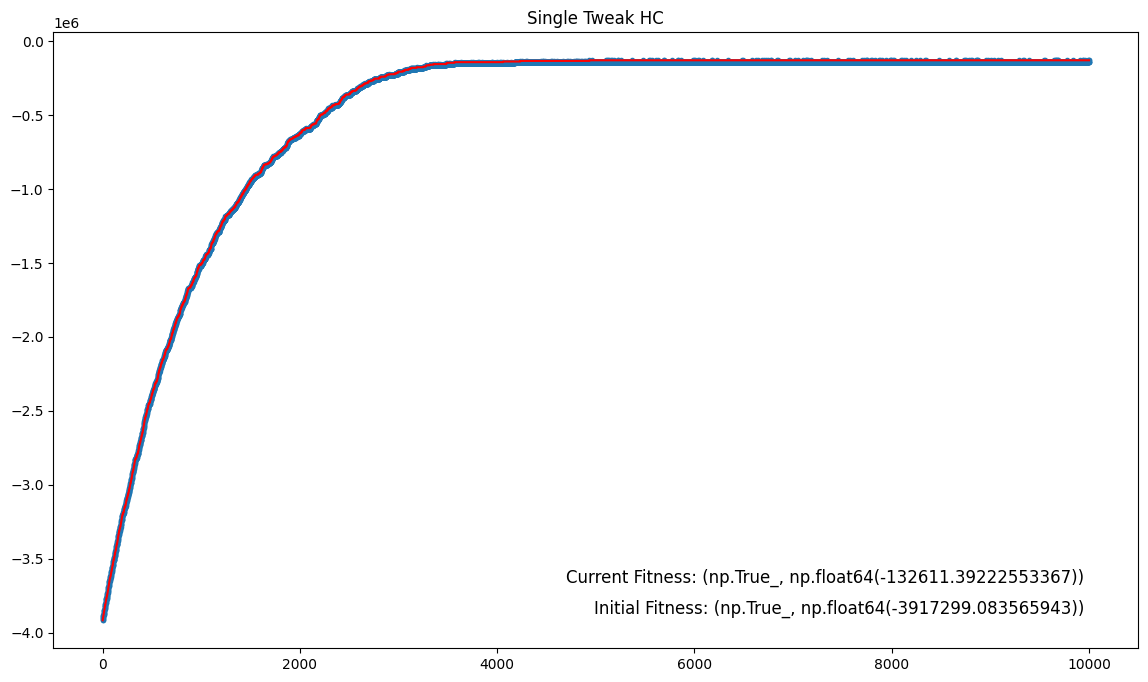

In [86]:
""" Computing the solution """
solution = starting_solution
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
history = [cur_fitness[1]]

for steps in range(10_000):
    new_solution = tweak__single(solution)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness

ic(fitness(solution))

""" Plotting the solution exploration """
plt.figure(figsize=(14, 8))
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )          
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks
plt.title("Single Tweak HC")
plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


# Single/Double Tweak HC

ic| fitness(solution): (np.True_, np.float64(-3917299.083565943))
ic| fitness(solution): (np.True_, np.float64(-126678.09284974133))
ic| fitness(solution): (np.True_, np.float64(-3917299.083565943))
ic| fitness(solution): (np.True_, np.float64(-128087.24633598686))


Text(0.95, 0.1, 'Current Fitness: (np.True_, np.float64(-128087.24633598686))')

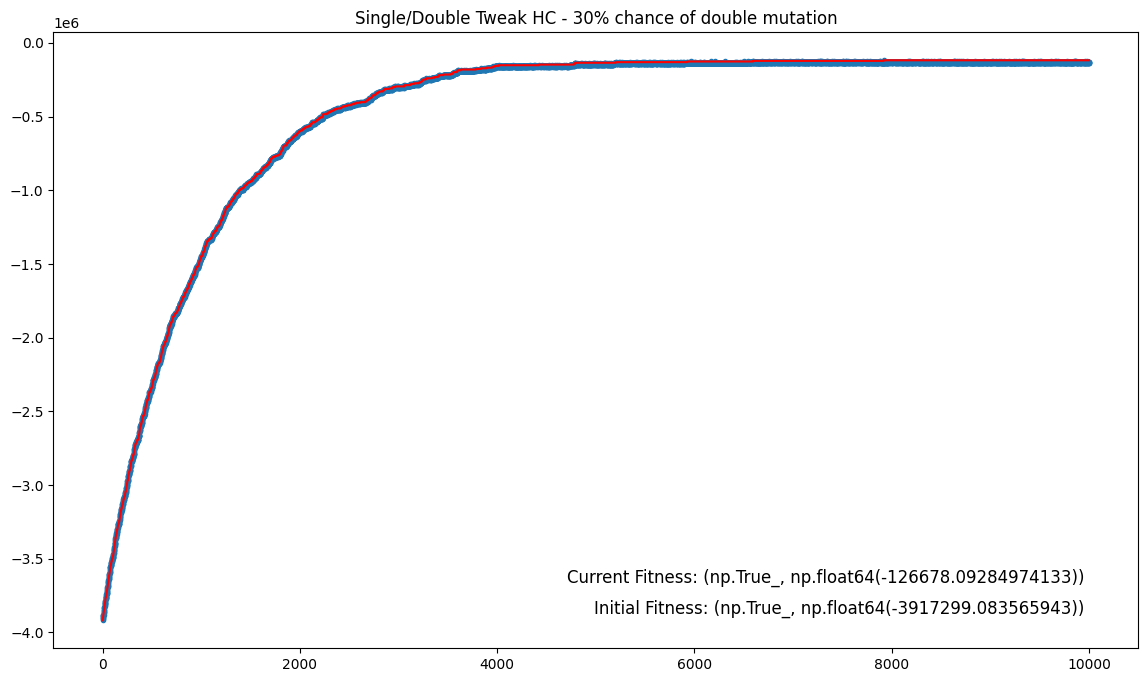

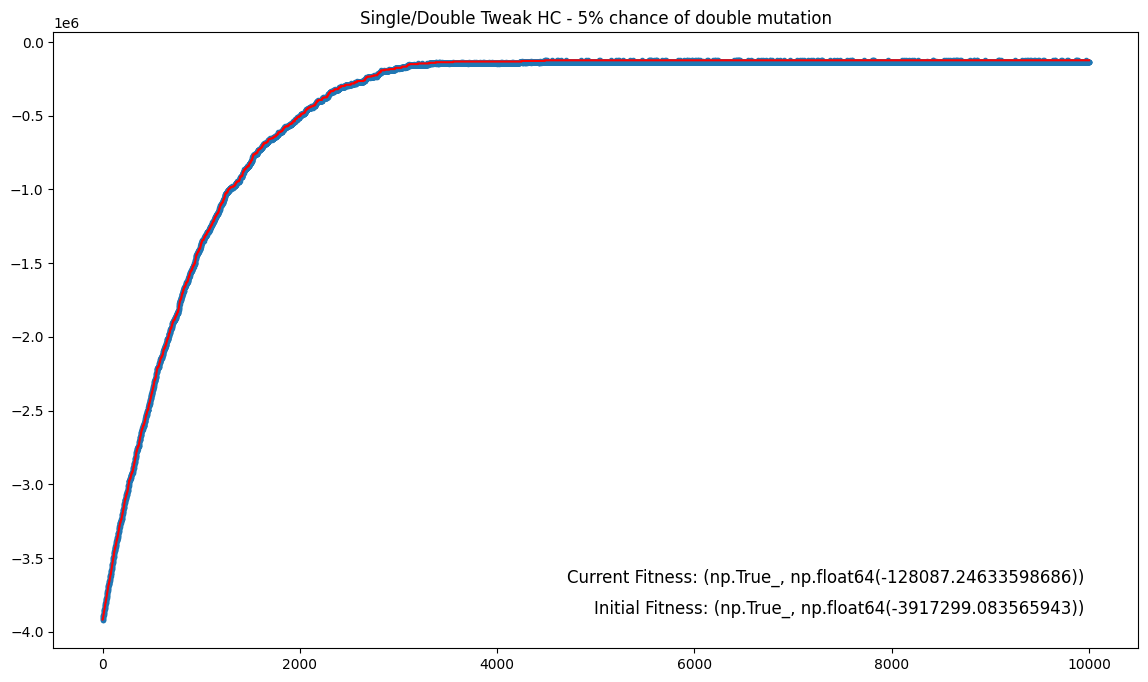

In [94]:
""" Computing the solution with more chance for double mutation """
solution = starting_solution
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

for steps in range(10_000):
    new_solution = tweak__single_or_double(solution, 0.3)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness

ic(fitness(solution))

""" Plotting the solution exploration """
plt.figure(figsize=(14, 8))
plt.title("Single/Double Tweak HC - 30% chance of double mutation")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )
            
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


""" ========================================================================================================================== """
""" Computing the solution with less chance for double mutation """
solution = starting_solution
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

for steps in range(10_000):
    new_solution = tweak__single_or_double(solution, 0.05)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness

ic(fitness(solution))

""" Plotting the solution exploration """
plt.figure(figsize=(14, 8))
plt.title("Single/Double Tweak HC - 5% chance of double mutation")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )
            
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


# Multiple Tweak HC

ic| fitness(solution): (np.True_, np.float64(-3917299.083565943))
ic| fitness(solution): (np.True_, np.float64(-1769833.5317435623))
ic| fitness(solution): (np.True_, np.float64(-3917299.083565943))
ic| fitness(solution): (np.True_, np.float64(-596530.6616801057))
ic| fitness(solution): (np.True_, np.float64(-3917299.083565943))
ic| fitness(solution): (np.True_, np.float64(-256644.0233168603))


Text(0.95, 0.1, 'Current Fitness: (np.True_, np.float64(-256644.0233168603))')

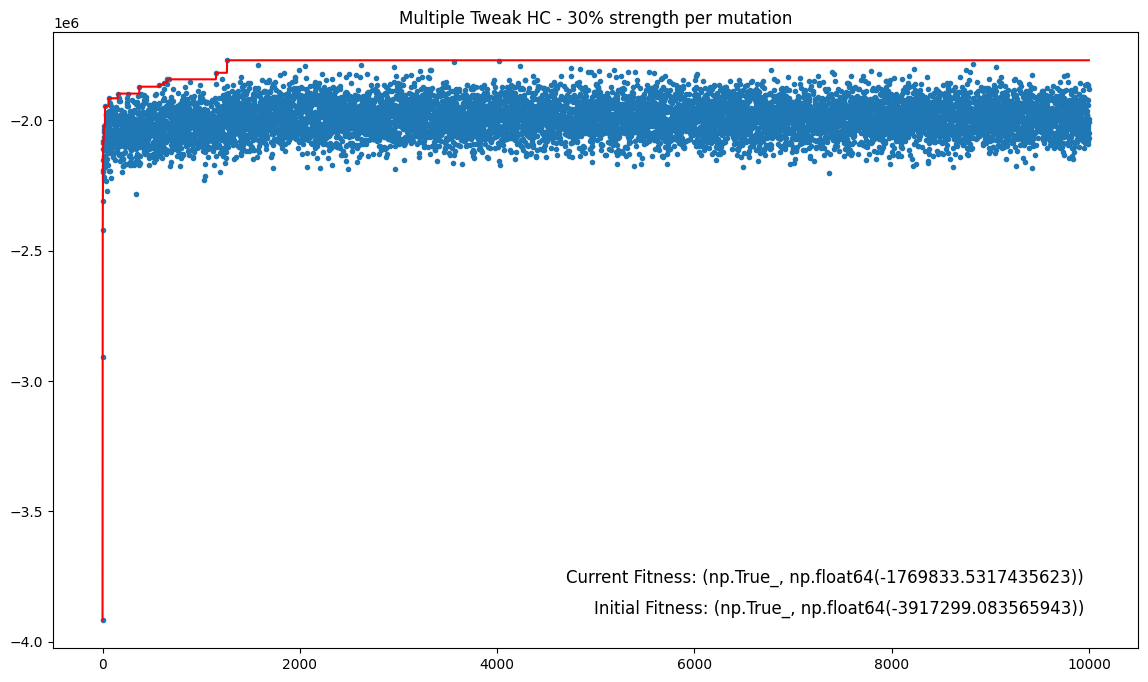

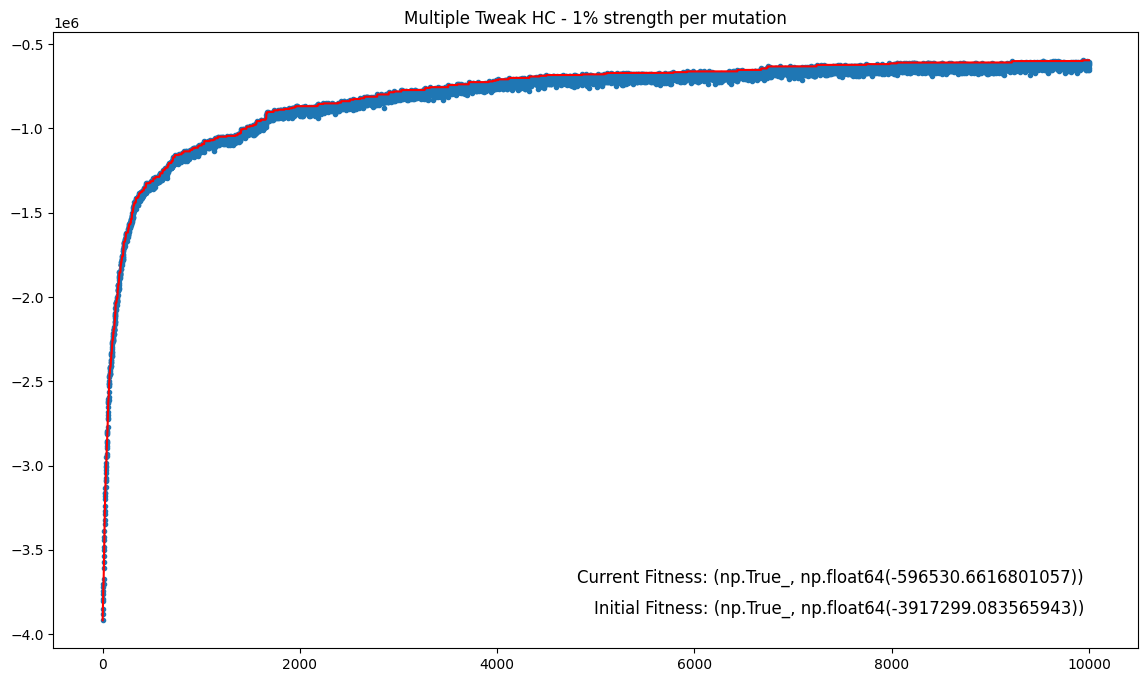

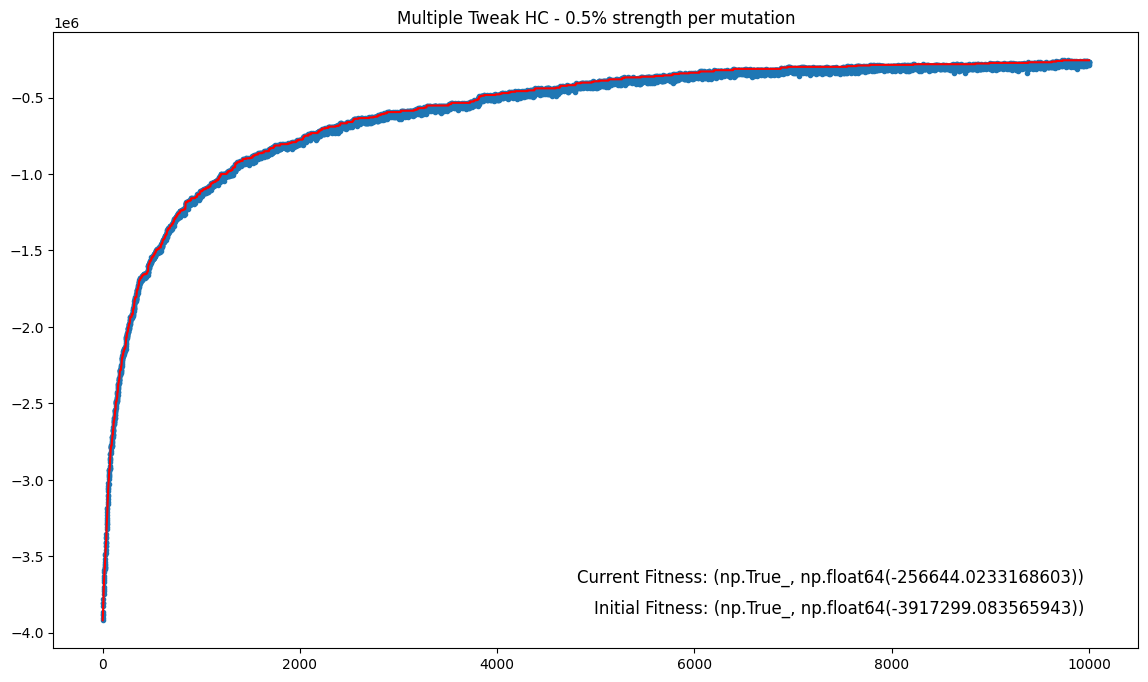

In [97]:
""" Computing the solution with high exploration """
solution = starting_solution
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

for steps in range(10_000):
    new_solution = tweak__multiple(solution, 0.3)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness

ic(fitness(solution))

""" Plotting the solution """
plt.figure(figsize=(14, 8))
plt.title("Multiple Tweak HC - 30% strength per mutation")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )
            
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


""" ============================================================================================================ """
""" Computing the solution with lower exploration """
solution = starting_solution
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

for steps in range(10_000):
    new_solution = tweak__multiple(solution, 0.01)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness

ic(fitness(solution))

""" Plotting the solution """
plt.figure(figsize=(14, 8))
plt.title("Multiple Tweak HC - 1% strength per mutation")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )
            
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')

""" ============================================================================================================ """
""" Computing the solution with EVEN lower exploration """
solution = starting_solution
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

for steps in range(10_000):
    new_solution = tweak__multiple(solution, 0.005)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness

ic(fitness(solution))

""" Plotting the solution """
plt.figure(figsize=(14, 8))
plt.title("Multiple Tweak HC - 0.5% strength per mutation")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )
            
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


# HC - Exploration/Exploitation Through Strength Update For Multiple Tweak Following rule-of-5

ic

| fitness(solution): (np.True_, np.float64(-3917299.083565943))
ic| fitness(solution): (np.True_, np.float64(-128562.54026881438))


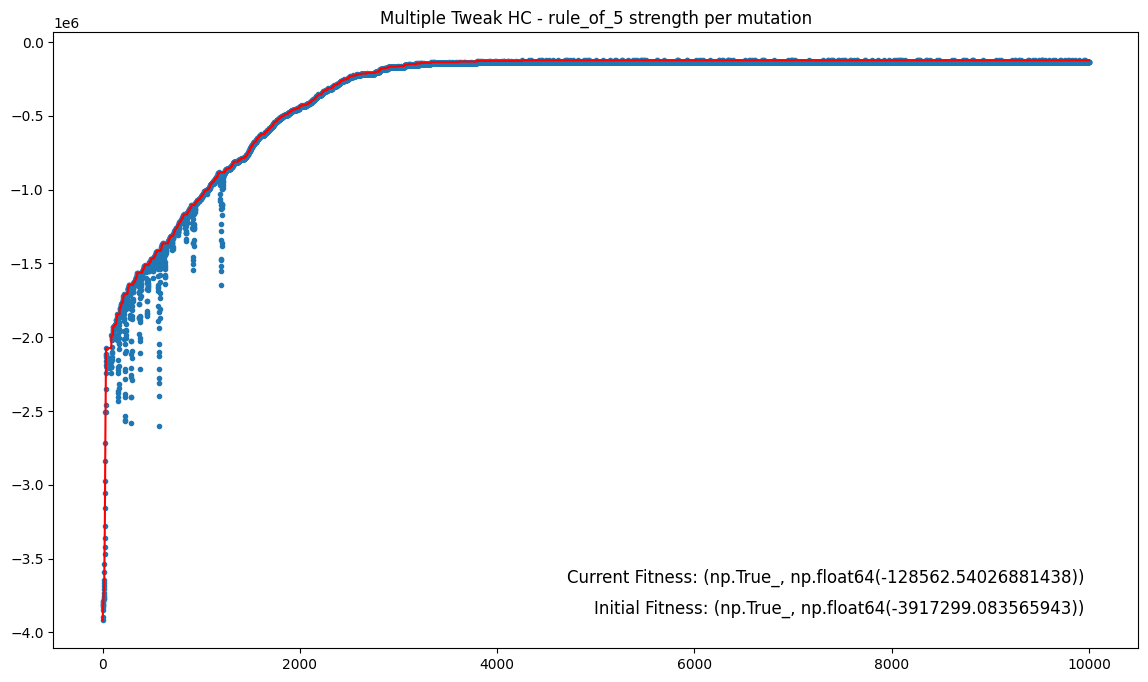

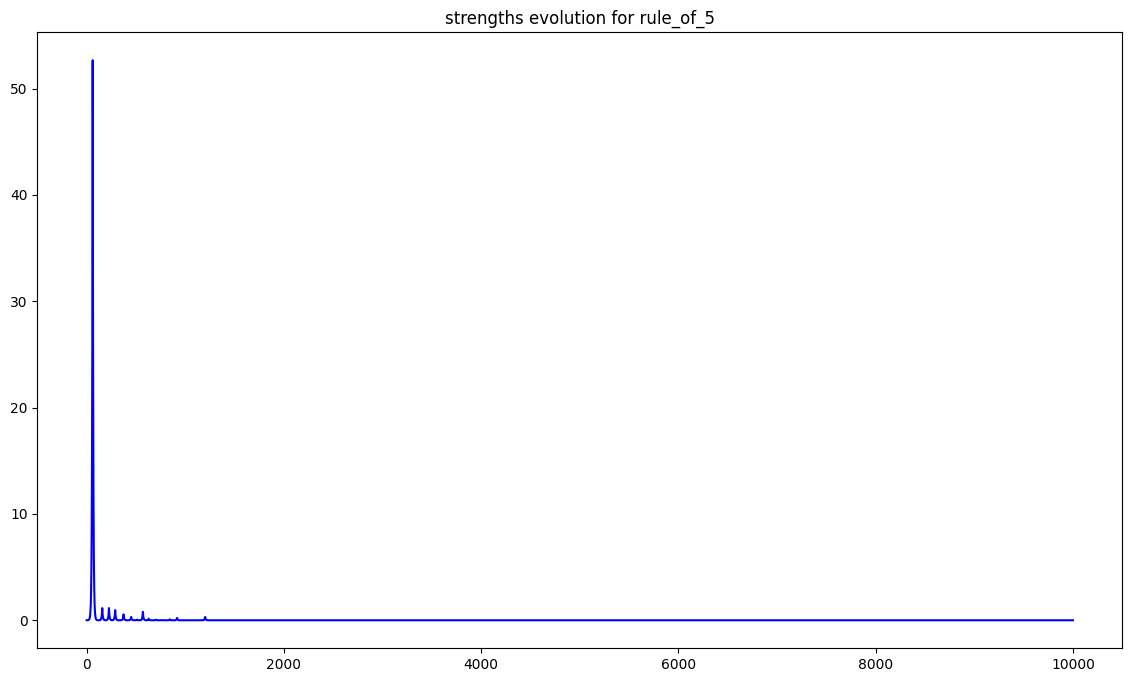

In [90]:
""" ============================================================================================================ """
""" Computing the solution with rule of 5 for tweak strength """
BUFFER_SIZE = 35 # keep it a multiple of 5
buffer = deque(maxlen=BUFFER_SIZE)

solution = starting_solution
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

strength = 0.01
strength_multiplier = 1.2
strengths = [strength]
for steps in range(10_000):
    new_solution = tweak__multiple(solution, strength)
    new_fitness = fitness(new_solution)
    history.append(new_fitness[1])

    buffer.append(new_fitness > cur_fitness)
    if sum(buffer) >= BUFFER_SIZE / 5:
        strength *= strength_multiplier
    elif sum(buffer) < BUFFER_SIZE / 5:
        strength /= strength_multiplier
    strengths.append(strength)

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness    

ic(fitness(solution))

""" Plotting the solution """
plt.figure(figsize=(14, 8))
plt.title("Multiple Tweak HC - rule_of_5 strength per mutation")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )

_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks
plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


""" Plotting the strengths """
plt.figure(figsize=(14, 8))
plt.title("strengths evolution for rule_of_5")
plt.plot(range(len(strengths)), strengths, color="blue")

# HC - Eploration/Exploitation Through Probability Of Taking Random Jumps

ic| fitness(solution): (np.True_, np.float64(-3917299.083565943))
ic| fitness(best_solution_ever): (np.True_, np.float64(-150546.95804277458))
ic| fitness(solution): (np.True_, np.float64(-3917299.083565943))
ic| fitness(best_solution_ever): (np.True_, np.float64(-124259.15997779848))


Text(0.95, 0.1, 'Current Fitness: (np.True_, np.float64(-124259.15997779848))')

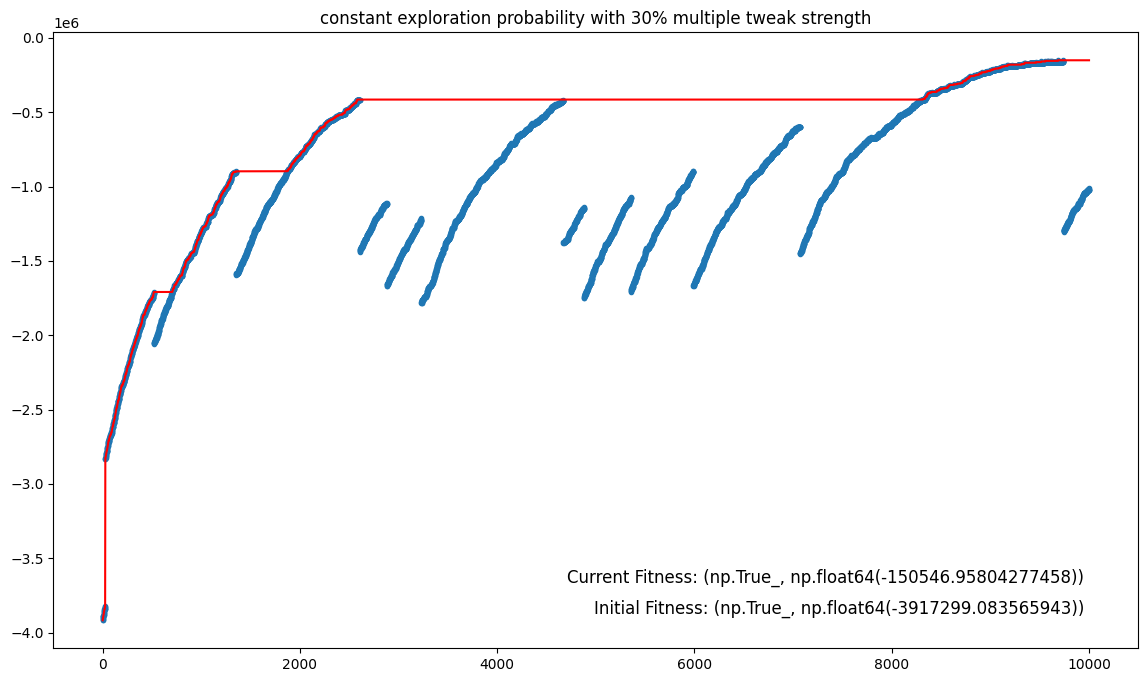

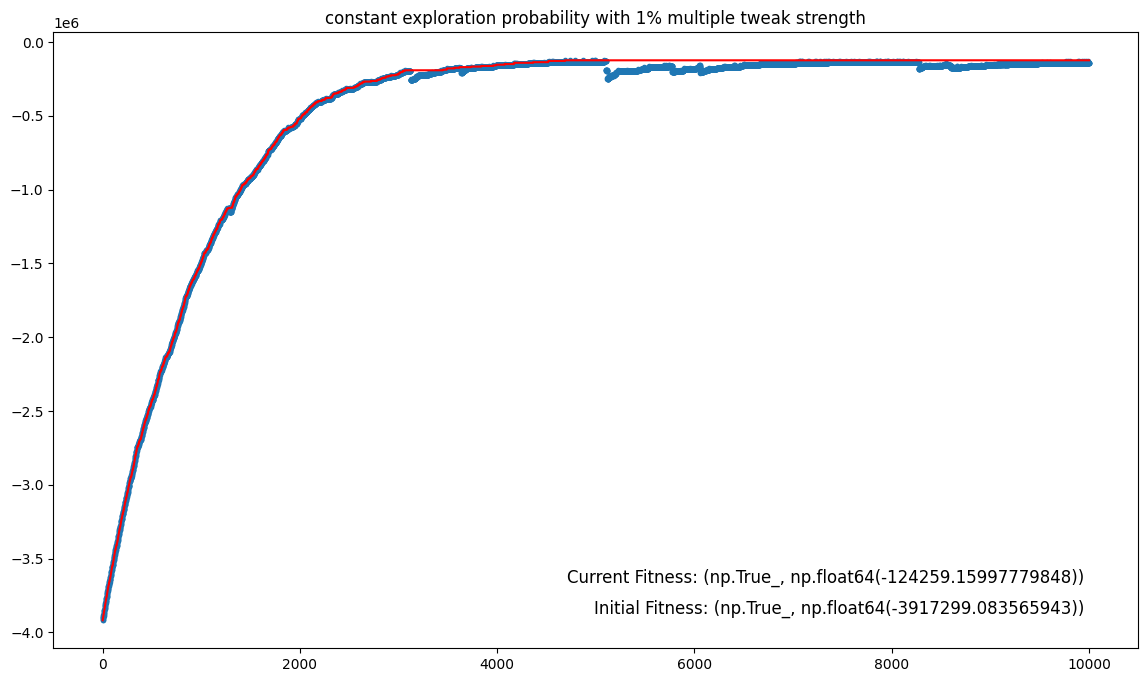

In [91]:
""" Computing the solution with more exploration """
solution = starting_solution
best_solution_ever = solution # This is needed because we allow for worse solutions to be accepted
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

for steps in range(10_000):
    if rng.random() < 0.001:
        new_solution = tweak__multiple(solution, 0.3)
        new_fitness = fitness(new_solution)
        history.append(new_fitness[1])

        solution = new_solution
        cur_fitness = new_fitness
    else:
        new_solution = tweak__single(solution)
        new_fitness = fitness(new_solution)
        history.append(new_fitness[1])

        if new_fitness > cur_fitness:
            solution = new_solution
            cur_fitness = new_fitness
    
    if cur_fitness > fitness(best_solution_ever):
        best_solution_ever = solution
        

ic(fitness(best_solution_ever))

""" Plotting the solution exploration """
plt.figure(figsize=(14, 8))
plt.title("constant exploration probability with 30% multiple tweak strength")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )
            
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {fitness(best_solution_ever)}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


""" ============================================================================================================ """
""" Computing the solution with less exploration """
solution = starting_solution
best_solution_ever = solution # This is needed because we allow for worse solutions to be accepted
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness[1]]

for steps in range(10_000):
    if rng.random() < 0.001:
        new_solution = tweak__multiple(solution, 0.01)
        new_fitness = fitness(new_solution)
        history.append(new_fitness[1])

        solution = new_solution
        cur_fitness = new_fitness
    else:
        new_solution = tweak__single(solution)
        new_fitness = fitness(new_solution)
        history.append(new_fitness[1])

        if new_fitness > cur_fitness:
            solution = new_solution
            cur_fitness = new_fitness

    if cur_fitness > fitness(best_solution_ever):
        best_solution_ever = solution
        

ic(fitness(best_solution_ever))

""" Plotting the solution exploration """
plt.figure(figsize=(14, 8))
plt.title("constant exploration probability with 1% multiple tweak strength")
plt.plot(   range(len(history)), # Growth-only Tweaks
            list(accumulate(history, max)),
            color="red"
            )
            
_ = plt.scatter(range(len(history)), history, marker=".") # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Current Fitness: {fitness(best_solution_ever)}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


# Single/Double HC - Simulated Annealing

ic| fitness(solution): (np.True_, np.float64(-3917299.083565943))
ic| temperature: np.float64(1.778279410038923), step_temperature: 0.01
ic| best_fitness_ever: (np.True_, np.float64(-122938.88980724693))


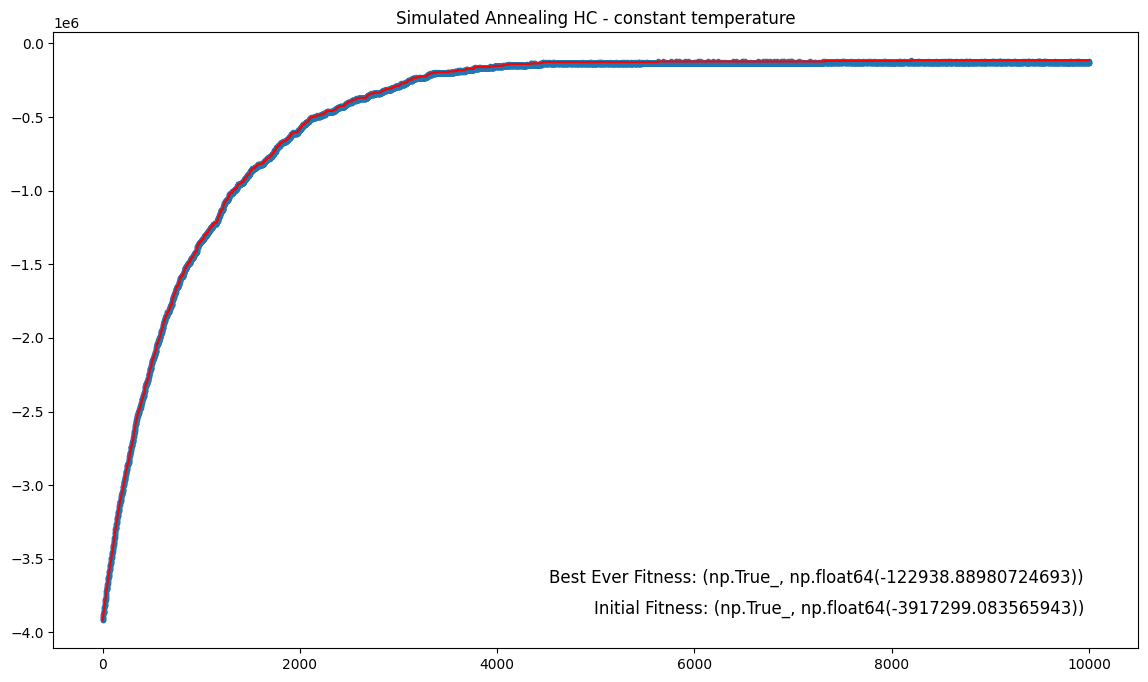

ic| fitness(solution): (np.True_, np.float64(-3917299.083565943))
ic| temperature: np.float64(1.778279410038923), step_temperature: 0.01
ic| best_fitness_ever: (np.True_, np.float64(-122296.7464372587))


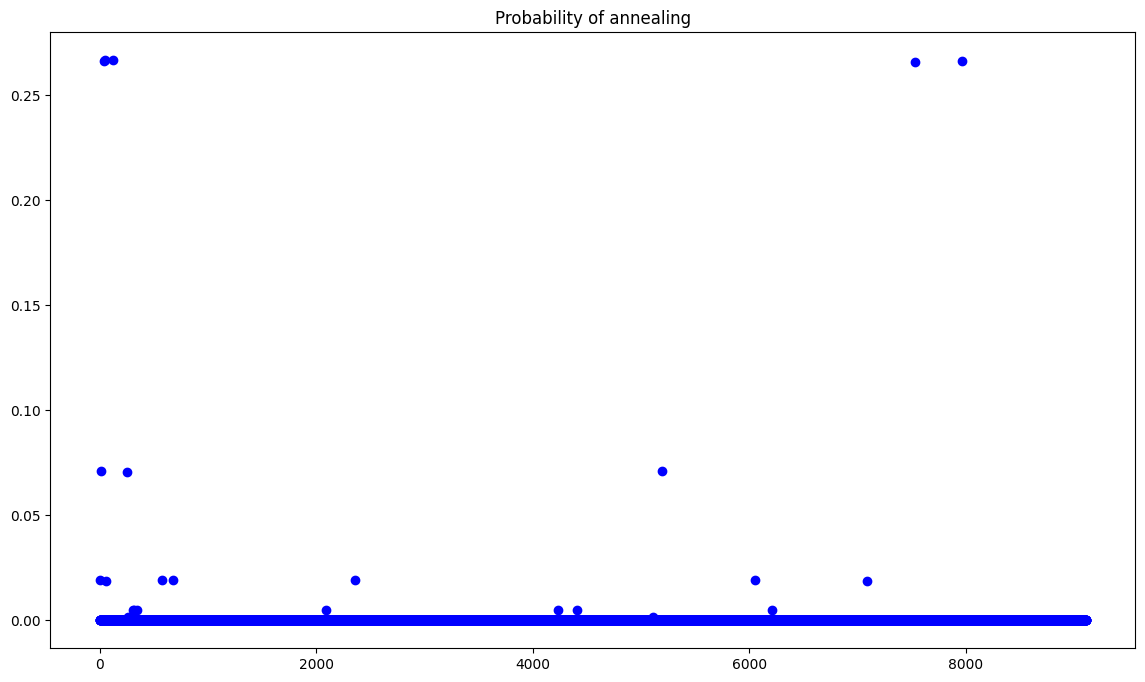

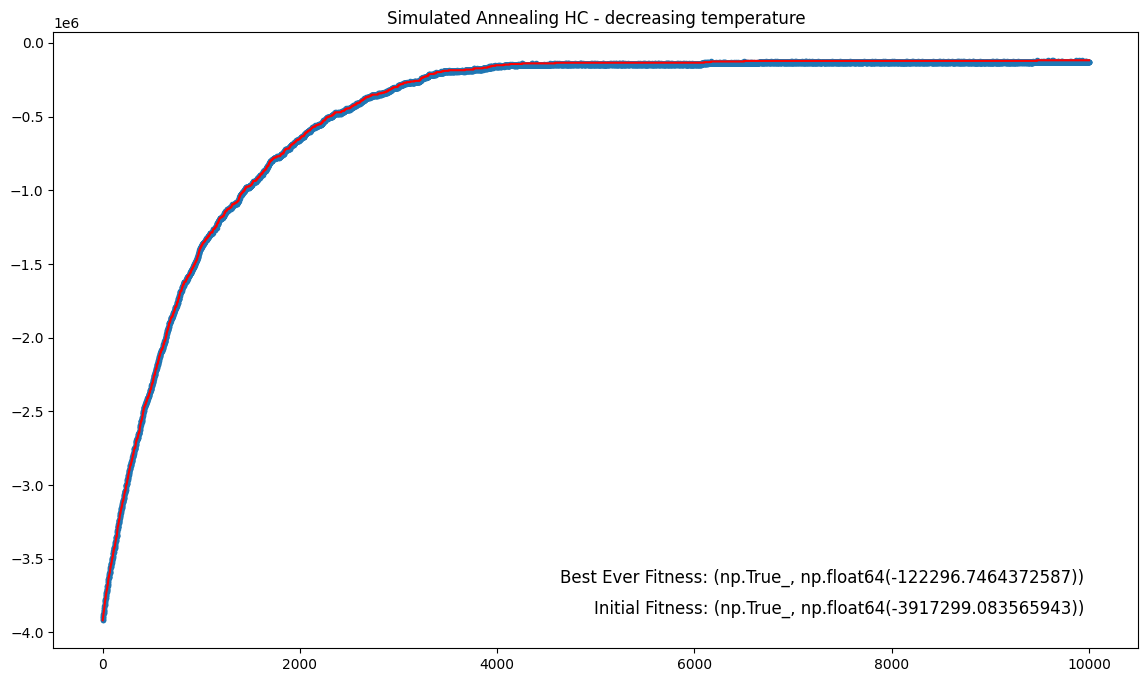

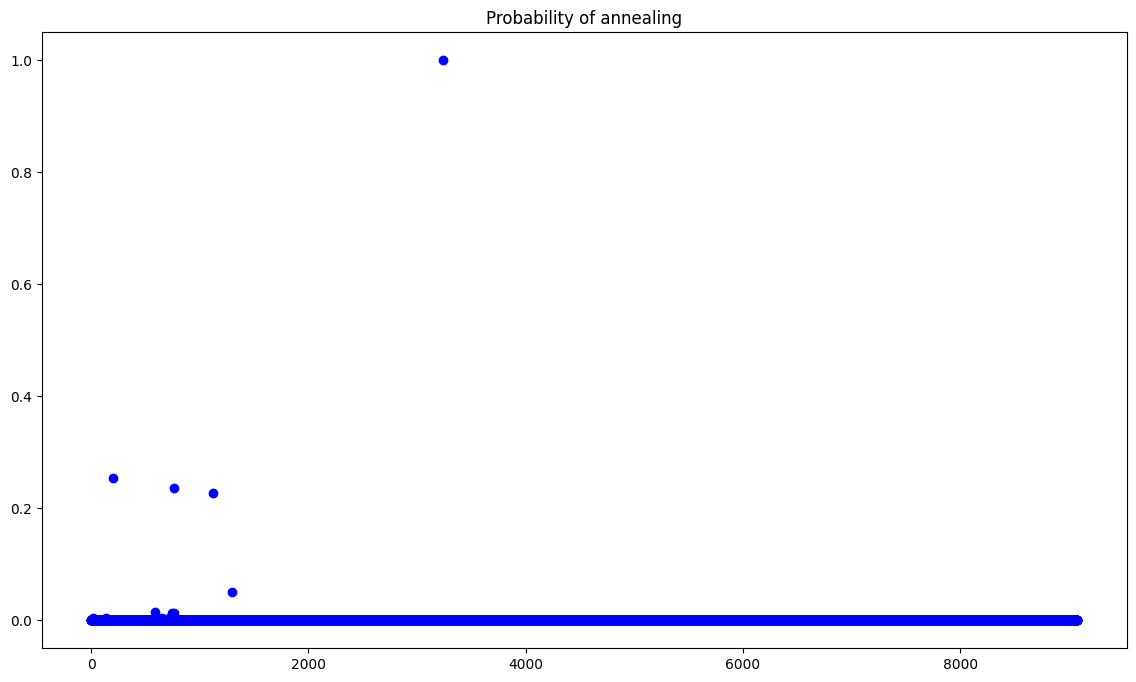

In [92]:
""" Computing the solution with constant temperature """
solution = starting_solution
best_solution_ever = solution  # This is needed because we allow for worse solutions to be accepted
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness]
ps = []
difs = []

temperature = np.exp(np.log(UNIVERSE_SIZE) / 16)
step_temperature = 0.01
ic(temperature, step_temperature)

for steps in range(10_000):
    new_solution = tweak__single_or_double(solution, 0.3)
    new_fitness = fitness(new_solution)
    history.append(new_fitness)

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness
    elif new_fitness == cur_fitness:
        continue
    else:
        p = np.exp(-(np.abs(cur_fitness[1] - new_fitness[1])) / temperature)
        ps.append(p)
        difs.append(np.abs(cur_fitness[1] - new_fitness[1]))

        if rng.random() < p:
            solution = new_solution
            cur_fitness = new_fitness

    if cur_fitness > fitness(best_solution_ever):
        best_solution_ever = solution

best_fitness_ever = fitness(best_solution_ever)
ic(best_fitness_ever)

""" Plotting the solution exploration """
plt.figure(figsize=(14, 8))
plt.title("Simulated Annealing HC - constant temperature")
plt.plot(
    range(len(history)),  # Growth-only Tweaks
    list(accumulate([f[1] for f in history], max)),
    color="red"
)
_ = plt.scatter(range(len(history)), [f[1] for f in history], marker=".")  # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Best Ever Fitness: {best_fitness_ever}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')

plt.show()

""" Plotting the probabilities of annealing """
plt.figure(figsize=(14, 8))
plt.title("Probability of annealing")
plt.scatter(
    range(len(ps)),
    ps,  # probability of accepting worse solution
    color="blue"
)
# plt.scatter(   range(len(difs)),
#             difs,
#             color="yellow"
#             )

""" ========================================================================================================================== """
""" Computing the solution with temperature descent """
solution = starting_solution
best_solution_ever = solution  # This is needed because we allow for worse solutions to be accepted
cur_fitness = fitness(solution)
initial_fitness = cur_fitness
ic(fitness(solution))
history = [cur_fitness]
ps = []
difs = []

temperature = np.exp(np.log(UNIVERSE_SIZE) / 16)
step_temperature = 0.01
ic(temperature, step_temperature)

for steps in range(10_000):
    new_solution = tweak__single_or_double(solution, 0.3)
    new_fitness = fitness(new_solution)
    history.append(new_fitness)

    if new_fitness > cur_fitness:
        solution = new_solution
        cur_fitness = new_fitness
    elif new_fitness == cur_fitness:
        continue
    else:
        p = np.exp(-(np.abs(cur_fitness[1] - new_fitness[1])) / temperature)
        ps.append(p)
        difs.append(np.abs(cur_fitness[1] - new_fitness[1]))

        if rng.random() < p:
            solution = new_solution
            cur_fitness = new_fitness

    if cur_fitness > fitness(best_solution_ever):
        best_solution_ever = solution

    if steps % 100 == 0:
        temperature -= step_temperature if temperature > 0 else step_temperature

best_fitness_ever = fitness(best_solution_ever)
ic(best_fitness_ever)

""" Plotting the solution exploration """
plt.figure(figsize=(14, 8))
plt.title("Simulated Annealing HC - decreasing temperature")
plt.plot(
    range(len(history)),  # Growth-only Tweaks
    list(accumulate([f[1] for f in history], max)),
    color="red"
)
_ = plt.scatter(range(len(history)), [f[1] for f in history], marker=".")  # All Tweaks

plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.text(0.95, 0.10, f'Best Ever Fitness: {best_fitness_ever}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')

plt.show()

""" Plotting the probabilities of annealing """
plt.figure(figsize=(14, 8))
plt.title("Probability of annealing")
plt.scatter(
    range(len(ps)),
    ps,  # probability of accepting worse solution
    color="blue"
)
# plt.scatter(   range(len(difs)),
#             difs,
#             color="yellow"
#             )